# Partial Differential Equation

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import mpl_toolkits.mplot3d

In [3]:
import scipy.sparse as sp
import scipy.sparse.linalg as spl
import scipy.linalg as la

In [4]:
import dolfin
import mshr

In [5]:
N = 5
u0, u1 = 1,2
dx = 1./(N+1)

In [6]:
A = (np.eye(N, k = -1) - 2*np.eye(N) + np.eye(N, k=1))/dx**2
A

array([[-72.,  36.,   0.,   0.,   0.],
       [ 36., -72.,  36.,   0.,   0.],
       [  0.,  36., -72.,  36.,   0.],
       [  0.,   0.,  36., -72.,  36.],
       [  0.,   0.,   0.,  36., -72.]])

In [7]:
b = -5*np.ones(N)
b[0] -= u0/dx**2
b[N-1] -= u1/dx**2

In [8]:
u = la.solve(A,b)

Text(0, 0.5, '$u(x)$')

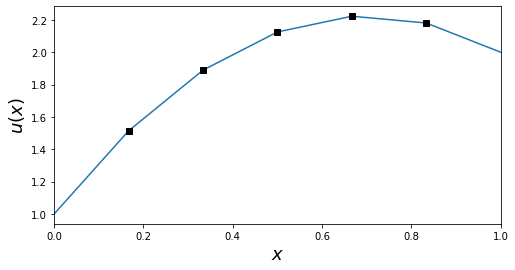

In [9]:
x = np.linspace(0,1,N+2)
U = np.hstack([[u0], u, [u1]])
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(x,U)
ax.plot(x[1:-1], u, 'ks')
ax.set_xlim(0,1)
ax.set_xlabel(r"$x$", fontsize=18)
ax.set_ylabel(r"$u(x)$", fontsize=18)

In [10]:
N = 100
u0_t, u0_b = 5, -5
u0_l, u0_r = 3,-1
dx = 1./(N+1)

In [11]:
A_1d = (sp.eye(N,k=-1) + sp.eye(N,k=1)- 4*sp.eye(N))/dx**2
A = sp.kron(sp.eye(N), A_1d)+ (sp.eye(N**2, k=-N)+ sp.eye(N**2, k=N))/dx**2
A

<10000x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 49600 stored elements in Compressed Sparse Row format>

In [12]:
b = np.zeros((N,N))
b[0,:]+=u0_b
b[-1,:]+=u0_t
b[:,0]+=u0_l
b[:,-1]+=u0_r
b = -b.reshape(N**2)/dx**2

In [13]:
v = spl.spsolve(A,b)
u = v.reshape(N,N)

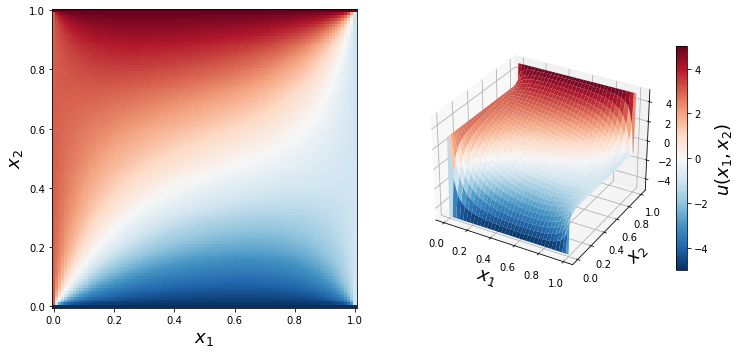

In [14]:
U = np.vstack([np.ones((1, N+2))*u0_b, np.hstack([np.ones((N,1))*u0_l, u, np.ones((N,1))*u0_r]), np.ones((1,N+2))*u0_t])
x = np.linspace(0,1,N+2)

X,Y = np.meshgrid(x,x)
fig = plt.figure(figsize=(12,5.5))
cmap = mpl.cm.get_cmap('RdBu_r')

ax = fig.add_subplot(1,2,1)
c = ax.pcolor(X,Y,U, vmin=-5, vmax=5, cmap=cmap, shading ='auto')
ax.set_xlabel(r"$x_1$", fontsize=18)
ax.set_ylabel(r"$x_2$", fontsize=18)

ax = fig.add_subplot(1,2,2,projection='3d')
p = ax.plot_surface(X,Y,U, vmin=-5, vmax = 5, rstride=3, cstride=3, linewidth=0, cmap=cmap)
ax.set_xlabel(r"$x_1$", fontsize=18)
ax.set_ylabel(r"$x_2$", fontsize=18)

cb = plt.colorbar(p, ax = ax, shrink=0.75)
cb.set_label(r"$u(x_1,x_2)$",fontsize=18)

In [15]:
A_dense = A.todense()
%timeit la.solve(A_dense, b)

5.58 s ± 418 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
%timeit spl.spsolve(A, b)

24.5 ms ± 574 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [17]:
dolfin.parameters["reorder_dofs_serial"] = False
dolfin.parameters["allow_extrapolation"] = True

In [19]:
N1 = N2 = 75
mesh = dolfin.RectangleMesh(dolfin.Point(0,0), dolfin.Point(1,1), N1, N2)
dolfin.RectangleMesh(dolfin.Point(0,0), dolfin.Point(1,1),10, 10)

In [20]:
V = dolfin.FunctionSpace(mesh, 'Lagrange', 1)

Calling FFC just-in-time (JIT) compiler, this may take some time.


In [21]:
u = dolfin.TrialFunction(V)
v = dolfin.TestFunction(V)

In [22]:
a = dolfin.inner(dolfin.nabla_grad(u), dolfin.nabla_grad(v))*dolfin.dx

In [23]:
f1 = dolfin.Constant(1.0)
L1 = f1*v*dolfin.dx

In [24]:
f2 = dolfin.Expression("x[0]*x[0]+x[1]*x[1]",degree=1)
L2 = f2*v*dolfin.dx

In [25]:
u0 = dolfin.Constant(0)

In [26]:
def u0_boundary(x, on_boundary):
    return on_boundary

In [27]:
bc = dolfin.DirichletBC(V,u0,u0_boundary)

In [28]:
A = dolfin.assemble(a)
b = dolfin.assemble(L1)
bc.apply(A,b)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


In [29]:
u_sol1 = dolfin.Function(V)
dolfin.solve(A, u_sol1.vector(), b)

1

In [30]:
u_sol2 = dolfin.Function(V)
dolfin.solve(a == L2, u_sol2, bc)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Solving linear variational problem.


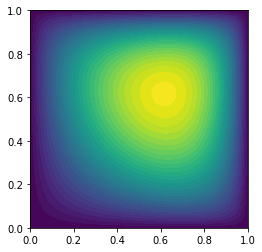

In [31]:
dolfin.plot(u_sol2)

In [32]:
dolfin.File('u_sol1.pvd')<<u_sol1

In [33]:
f = dolfin.File('u_sol_and_mesh.pvd')
f<<mesh
f<<u_sol1
f<<u_sol2

In [34]:
u_sol1([0.21,0.67])

0.046607699778135905

In [35]:
u_mat1 = np.array(u_sol1.vector()).reshape(N1+1, N2+1)
u_mat2 = np.array(u_sol2.vector()).reshape(N1+1, N2+1)
X, Y = np.meshgrid(np.linspace(0,1,N1+2), np.linspace(0,1,N2+2))

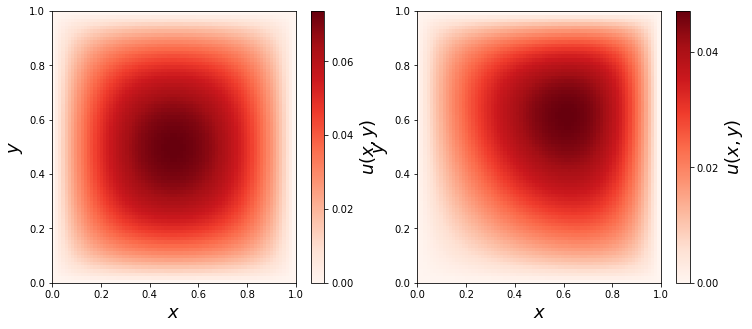

In [40]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,5))
c = ax1.pcolor(X,Y, u_mat1, cmap=mpl.cm.get_cmap('Reds'))
cb = plt.colorbar(c,ax=ax1)
ax1.set_xlabel(r"$x$",fontsize=18)
ax1.set_ylabel(r"$y$",fontsize=18)
cb.set_label(r"$u(x,y)$",fontsize=18)
cb.set_ticks([0., 0.02, 0.04,0.06])

c = ax2.pcolor(X,Y, u_mat2, cmap=mpl.cm.get_cmap('Reds'))
cb = plt.colorbar(c,ax=ax2)
ax2.set_xlabel(r"$x$",fontsize=18)
ax2.set_ylabel(r"$y$",fontsize=18)
cb.set_label(r"$u(x,y)$",fontsize=18)
cb.set_ticks([0., 0.02, 0.04,0.06])

In [41]:
coordinates = mesh.coordinates()
triangles = mesh.cells()
triangulation = mpl.tri.Triangulation(coordinates[:,0], coordinates[:,1], triangles)

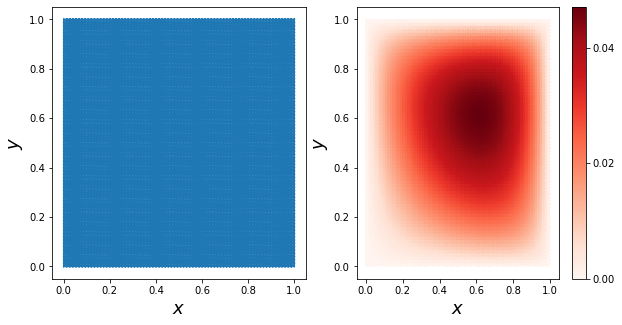

In [56]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5))
ax1.triplot(triangulation)
ax1.set_xlabel(r"$x$",fontsize=18)
ax1.set_ylabel(r"$y$",fontsize=18)
cmap = mpl.cm.get_cmap('Reds')
c = ax2.tripcolor(triangulation, np.array(u_sol2.vector()), cmap=cmap)
cb = plt.colorbar(c,ax=ax2)
ax2.set_xlabel(r"$x$",fontsize=18)
ax2.set_ylabel(r"$y$", fontsize=18)
cb.set_ticks([0.,0.02, 0.04])

In [57]:
V = dolfin.FunctionSpace(mesh, 'Lagrange', 1)
u = dolfin.TrialFunction(V)
v = dolfin.TestFunction(V)

In [58]:
a = dolfin.inner(dolfin.nabla_grad(u), dolfin.nabla_grad(v))*dolfin.dx
f = dolfin.Constant(0.)
L = f*v*dolfin.dx

In [61]:
def u0_top_boundary(x, on_boundary):
    return on_boundary and abs(x[1]-1)<1e-5

def u0_bottom_boundary(x, on_boundary):
    return on_boundary and abs(x[1])<1e-5

def u0_left_boundary(x, on_boundary):
    return on_boundary and abs(x[0])<1e-5

def u0_right_boundary(x, on_boundary):
    return on_boundary and abs(x[0]-1)<1e-5

bc_t = dolfin.DirichletBC(V,dolfin.Constant(5), u0_top_boundary)
bc_b = dolfin.DirichletBC(V,dolfin.Constant(-5), u0_bottom_boundary)
bc_l = dolfin.DirichletBC(V,dolfin.Constant(3), u0_left_boundary)
bc_r = dolfin.DirichletBC(V,dolfin.Constant(-1), u0_right_boundary)

bcs = [bc_t, bc_b, bc_r, bc_l]

In [62]:
u_sol = dolfin.Function(V)
dolfin.solve(a == L, u_sol, bcs)
u_mat = np.array(u_sol.vector()).reshape(N1+1, N2+1)
x = np.linspace(0,1,N1+2)
y = np.linspace(0,1,N1+2)

X,Y = np.meshgrid(x,y)

  Solving linear variational problem.


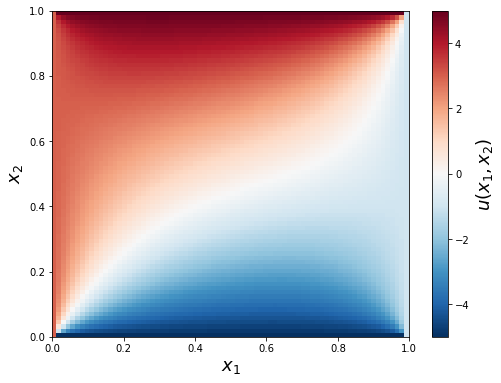

In [64]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
c = ax.pcolor(X,Y,u_mat, vmin=-5, vmax=5,cmap=mpl.cm.get_cmap('RdBu_r'))
cb = plt.colorbar(c, ax=ax)
ax.set_xlabel(r"$x_1$", fontsize=18)
ax.set_ylabel(r"$x_2$", fontsize=18)
cb.set_label(r"$u(x_1,x_2)$", fontsize=18)

In [89]:
r_outer = 1
r_inner = 0.25
r_middle = 0.1
x0, y0 = 0.4, 0.4

domain = mshr.Circle(dolfin.Point(.0, .0), r_outer)\
            - mshr.Circle(dolfin.Point(.0,.0), r_inner)\
            - mshr.Circle(dolfin.Point(x0,y0), r_middle)\
            - mshr.Circle(dolfin.Point(x0,-y0), r_middle)\
            - mshr.Circle(dolfin.Point(-x0,y0), r_middle)\
            - mshr.Circle(dolfin.Point(-x0,-y0), r_middle)


mesh = mshr.generate_mesh(domain,10)
#mesh

In [90]:
def u0_inner_boundary(x, on_boundary):
    x,y = x[0], x[1]
    return on_boundary and abs(np.sqrt(x**2 + y**2)-r_inner)<5e-2

def u0_middle_boundary(x, on_boundary):
    x,y = x[0], x[1]
    if on_boundary:
        for _x0 in [-x0, x0]:
            for _y0 in [-y0, y0]:
                if abs(np.sqrt((x-_x0)**2 + (y-_y0)**2) -r_middle)<5e-2:
                    return True
    return False

In [100]:
V = dolfin.FunctionSpace(mesh, 'Lagrange', 1)
u = dolfin.TrialFunction(V)
v = dolfin.TestFunction(V)
a = dolfin.inner(dolfin.nabla_grad(u), dolfin.nabla_grad(v))*dolfin.dx
f = dolfin.Constant(.0)
L = f*v*dolfin.dx
u_sol = dolfin.Function(V)

In [101]:
bc_inner = dolfin.DirichletBC(V,dolfin.Constant(15), u0_inner_boundary)
bc_middle = dolfin.DirichletBC(V,dolfin.Constant(0), u0_middle_boundary)
bcs = [bc_inner, bc_middle]

In [105]:
dolfin.solve(a == L, u_sol, bcs)
coordinates = mesh.coordinates()
triangles = mesh.cells()
triangulation = mpl.tri.Triangulation(coordinates[:,0], coordinates[:,1], triangles)

  Solving linear variational problem.


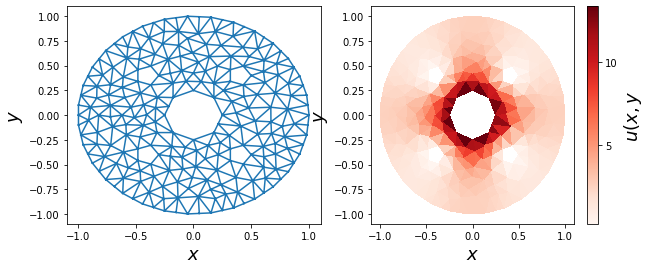

In [108]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,4))
ax1.triplot(triangulation)
ax1.set_xlabel(r"$x$", fontsize=18)
ax1.set_ylabel(r"$y$", fontsize=18)

c = ax2.tripcolor(triangulation, np.array(u_sol.vector()), cmap = mpl.cm.get_cmap('Reds'))
cb = plt.colorbar(c, ax=ax2)
ax2.set_xlabel(r"$x$", fontsize=18)
ax2.set_ylabel(r"$y$", fontsize=18)
cb.set_label(r"$u(x,y$", fontsize=18)

cb.set_ticks([.0, 5, 10, 15])

In [110]:
outer_boundary = dolfin.AutoSubDomain(lambda x, on_bnd: on_bnd and abs(np.sqrt(x[0]**2+x[1]**2)-r_outer)<5e-2)

In [111]:
bc_outer = dolfin.DirichletBC(V,1,outer_boundary)
mask_outer = dolfin.Function(V)
bc_outer.apply(mask_outer.vector())
u_outer = u_sol.vector()[mask_outer.vector() == 1]
x_outer = mesh.coordinates()[mask_outer.vector() == 1]

(-3.141592653589793, 3.141592653589793)

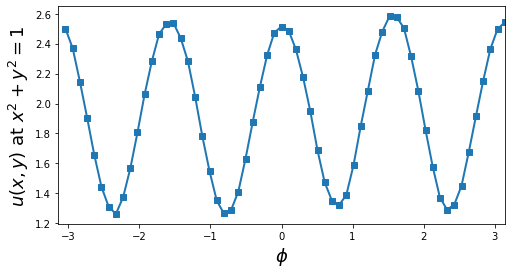

In [112]:
phi = np.angle(x_outer[:,0] + 1j* x_outer[:,1])
order = np.argsort(phi)
fig, ax = plt.subplots(1,1, figsize=(8,4))
ax.plot(phi[order], u_outer[order], 's-', lw=2)
ax.set_xlabel(r"$\phi$", fontsize=18)
ax.set_ylabel(r"$u(x,y)$ at $x^2+y^2 = 1$", fontsize=18)
ax.set_xlim(-np.pi, np.pi)

In [136]:
domain = mshr.Circle(dolfin.Point(.0, .0),1.)\
            - mshr.Rectangle(dolfin.Point(.0, -1.), dolfin.Point(1.,.0))
mesh = mshr.generate_mesh(domain,10)
#mesh

In [137]:
refined_mesh = mesh
for r in [0.5, 0.25]:
    cell_markers = dolfin.MeshFunction("bool", refined_mesh, dim=2)
    cell_markers.set_all(False)
    for cell in dolfin.cells(refined_mesh):
        if cell.distance(dolfin.Point(.0, .0))<r:
            cell_markers[cell] = True
    refined_mesh = dolfin.refine(refined_mesh, cell_markers)
    

In [138]:
def mesh_triangulation(mesh):
    coordinates = mesh.coordinates()
    triangles = mesh.cells()
    triangulation = mpl.tri.Triangulation(coordinates[:,0], coordinates[:,1],triangles)
    return triangulation

Text(0, 0.5, '$y$')

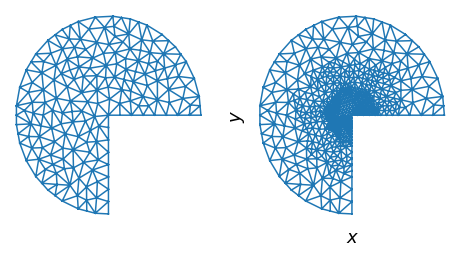

In [139]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(8,4))

ax1.triplot(mesh_triangulation(mesh))
ax2.triplot(mesh_triangulation(refined_mesh))
for ax in [ax1, ax2]:
    for side in ['bottom', 'right', 'top', 'left']:
        ax.spines[side].set_visible(False)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.xaxis.set_ticks_position('none')
        ax.yaxis.set_ticks_position('none')

ax.set_xlabel(r"$x$", fontsize=18)
ax.set_ylabel(r"$y$", fontsize=18)

In [140]:
mesh = refined_mesh
V = dolfin.FunctionSpace(mesh, 'Lagrange', 1)
u = dolfin.TrialFunction(V)
v = dolfin.TestFunction(V)

In [141]:
boundary_parts = dolfin.MeshFunction("size_t", mesh, mesh.topology().dim()-1)

In [142]:
def v_boundary_func(x, on_boundary):
    x,y = x[0], x[1]
    return on_boundary and abs(x)<1e-4 and y<0.

In [143]:
v_boundary = dolfin.AutoSubDomain(v_boundary_func)
v_boundary.mark(boundary_parts,0)

In [144]:
def h_boundary_func(x, on_boundary):
    x,y = x[0], x[1]
    return on_boundary and abs(y)<1e-4 and x>.0

In [145]:
h_boundary = dolfin.AutoSubDomain(h_boundary_func)
h_boundary.mark(boundary_parts,1)

In [146]:
def outer_boundary_func(x, on_boundary):
    x,y = x[0], x[1]
    return on_boundary and abs(x**2 + y**2-1)<1e-2

In [147]:
outer_boundary = dolfin.AutoSubDomain(outer_boundary_func)
outer_boundary.mark(boundary_parts,2)
bc = dolfin.DirichletBC(V, dolfin.Constant(.0), boundary_parts,2)

In [148]:
dx = dolfin.dx(domain=mesh, subdomain_data= boundary_parts)
a = dolfin.inner(dolfin.nabla_grad(u), dolfin.nabla_grad(v))*dx
f = dolfin.Constant(.0)
g_v = dolfin.Constant(-2.)
g_h = dolfin.Constant(1.)

L = f*v*dolfin.dx(domain=mesh, subdomain_data=boundary_parts)
L += g_v*v*dolfin.ds(0,domain=mesh, subdomain_data=boundary_parts)
L += g_h*v*dolfin.ds(1,domain=mesh, subdomain_data=boundary_parts)

In [149]:
u_sol = dolfin.Function(V)
dolfin.solve(a == L, u_sol, bc)

  Solving linear variational problem.


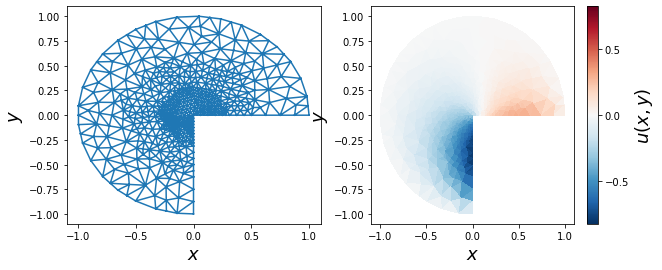

In [150]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,4))
triangulation = mesh_triangulation(mesh)
ax1.triplot(triangulation)
ax1.set_xlabel(r"$x$", fontsize=18)
ax1.set_ylabel(r"$y$", fontsize=18)


data = np.array(u_sol.vector())
norm = mpl.colors.Normalize(-abs(data).max(), abs(data).max())
c = ax2.tripcolor(triangulation, data, norm=norm, cmap=mpl.cm.get_cmap("RdBu_r"))
cb = plt.colorbar(c, ax=ax2)
ax2.set_xlabel(r"$x$", fontsize =18)
ax2.set_ylabel(r"$y$", fontsize =18)

cb.set_label(r"$u(x,y)$", fontsize=18)
cb.set_ticks([-.5, 0, .5])